In [1]:
import numpy as np
#import freud
from scipy.spatial import Voronoi,voronoi_plot_2d
#from scipy.spatial.distance import cdist
#from scipy.spatial import cKDTree
import matplotlib
import matplotlib.pyplot as plt
import time
from netCDF4 import Dataset
import os

#input begin with 1
varname = ['NO2','SO2','O3','PM2.5','PM10','CO']
varname2 = ['','','','PM25_TOT','','']
var = 4 
year = 2017
mon = 1
#---------

print(time.ctime())

print("read data")
lonlatcolrow = np.load('sitelonlatcolrowxy.npy')
ddata = np.load(str(year)+'_'+str(mon)+'_dailyobs.npy')
sim = Dataset(varname2[var-1]+"_"+str(year*100+mon)+".nc","r")
simdata = sim.variables[varname2[var-1]][:]


Mon Nov 30 14:20:30 2020
read data


In [2]:
obs = ddata[:,10,0]
obs[obs==-999] = 0
CTM = simdata[10].transpose(1,0).reshape(-1)
print(obs.shape,CTM.shape)

(1639,) (42224,)


In [76]:
def eVNA(obs,CTM,show = False):
    vor = Voronoi(lonlatcolrow[:,4:],qhull_options='Qbb Qc Qx')
    region_neighbor = [[] for _ in range(len(lonlatcolrow))]
    for i,j in vor.ridge_points:
        region_neighbor[i].append(j)
        region_neighbor[j].append(i)

    
    #to get the grid/cell cluster
    w = 232
    h = 182
    cell_cluster = -1*np.ones((232,182),dtype=np.int32)
    cell_pos = []
    for col in range(232):
        for row in range(182):
            cell_cluster[col,row] = np.argmin(np.sum((np.array([-3118.5+27*col,-2443.5+27*row])-lonlatcolrow[:,4:])**2,axis = -1))
            cell_pos.append([-3118.5+27*col,-2443.5+27*row])
    cell_pos = np.array(cell_pos)
    
    #get the region neighbor matrix
    max_neighbor = max([len(i) for i in region_neighbor])
    regions_sign = np.zeros((len(region_neighbor),max_neighbor),)
    for i in range(len(region_neighbor)):
        _l = len(region_neighbor[i])
        region_neighbor[i].extend([0]*(max_neighbor-_l))
#         region_neighbor[i] = region_neighbor[i]+[0]*(max_neighbor-_l)
        regions_sign[i,:_l] = 1
    region_neighbor  = np.array(region_neighbor)
    print(region_neighbor.shape)
    
    #get the cell's  region neighbor 
    cell_neighbor = region_neighbor[cell_cluster.reshape(-1)]
    print(cell_neighbor.shape)
    
    # get weight matrix
    weight = np.expand_dims(cell_pos,axis = 1)-lonlatcolrow[:,4:][cell_neighbor]
    weight = np.power(np.sum(weight**2,axis = -1),0.5) #distance
    weight = 1/weight**2
    weight = weight*regions_sign[cell_cluster.reshape(-1)]
    
    weight = np.expand_dims(weight,axis = 2)
    weight = weight*(obs[cell_neighbor]!=0)
    weight = weight/np.sum(weight,axis = 1,keepdims=True)
    print(weight.shape)
#     return weight
    
    #get the region's cell
    region_cell = np.array(lonlatcolrow[:,2]*182 + lonlatcolrow[:,3],np.int32) #[[] for _ in range(len(lonlatcolrow))]
    
    res2 = np.sum(weight*obs[cell_neighbor]/CTM[region_cell[cell_neighbor]],axis = 1)*CTM
    res = np.sum(weight*obs[cell_neighbor],axis = 1)

    #res is VNA
    #res2 is eVNA
    return res2

In [4]:
obs = ddata[:,:,3]
obs[obs==-999] = 0


In [5]:
obs = ddata[:,:,3]
obs[obs==-999] = 0

CTM = simdata.transpose(2,1,0).reshape(232*182,-1)

In [77]:
res = eVNA(obs,CTM)

print(res.shape)
res = res.reshape(232,182,-1)



(1639, 13)
(42224, 13)


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


(42224, 13, 31)
(42224, 31)


In [44]:
res.reshape(232,182,13,31)[100,100,:,5]

array([0.03977973, 0.0349156 , 0.20581575, 0.03600544, 0.04063377,
       0.18789887, 0.22871902, 0.22623182, 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [14]:
CTM.shape

(42224, 31)

In [18]:
obs.shape

(1639, 31)

In [20]:
obs_matrix = np.zeros((232,182,31))

In [22]:
for i in range(len(obs)):
    obs_matrix[int(lonlatcolrow[i,2]),int(lonlatcolrow[i,3]),] = obs[i]

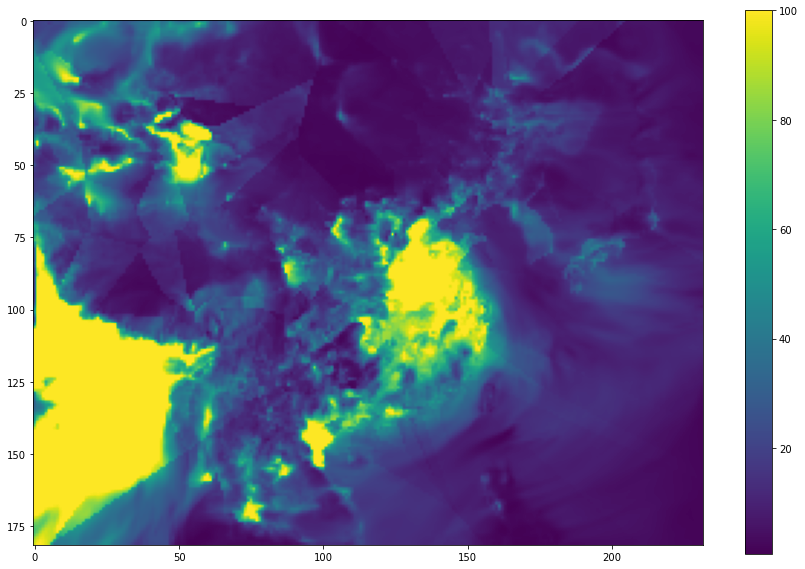

1


In [75]:
plt.rcParams['figure.figsize'] = (15,10)

for i in range(9,10):
#     c = CTM.reshape(232,182,-1)[:,:,i].transpose(1,0)[::-1]
#     c[c>100] = 100
#     plt.imshow(c)
#     plt.colorbar()
#     plt.show()
    
    
#     o = obs_matrix.reshape(232,182,-1)[:,:,i].transpose(1,0)[::-1]
#     o[o>100] = 100
#     plt.imshow(o)
#     plt.colorbar()
#     plt.show()
    
    
    V = res[:,:,i].transpose(1,0)[::-1]
    V[V>100] = 100
    plt.imshow(V)
    plt.colorbar()
    plt.show()
    
    print(1)
    


In [25]:
import numpy as np

In [ ]:


plt.imshow(res[:,:,9].transpose(1,0)[::-1])
plt.colorbar()
plt.show()

In [ ]:
res

In [91]:
a = np.load('eVNA_PM2.5_2017_1_d10.npy')

In [85]:
a[100:150,100:150]

masked_array(
  data=[[2.381745779659557, 1.269072117338645, 1.1292300692342323, ...,
         0.2419100461759056, 0.1865975000857958, 0.22010298006069418],
        [-1.8438731367925563, -0.9942410343136174, -0.9659254911445068,
         ..., 0.24342913871664784, 0.2687961478663392,
         0.23412167317235033],
        [-4.396668826478873, -4.119706464994813, -1.4543950746076462,
         ..., 0.26433798099828776, 0.3013695828256182,
         0.32882469024819105],
        ...,
        [3.0691228782207673, 8.69766783818504, 18.74577216160567, ...,
         0.8055343591104362, 0.5513781192873903, 0.34500973312785366],
        [-14.960307515145388, -0.4946150363416564, 3.7330894642639976,
         ..., 0.7631213214456909, 0.6743645627396395, 0.7838108708048432],
        [38.69571803218918, 4.099735617410012, -6.308385421200207, ...,
         0.4373293267165357, 0.747202299766216, 0.7541984037012686]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False,

In [93]:
a = np.abs(a)
a[a>100] = 100

In [80]:
a.shape

(232, 182)

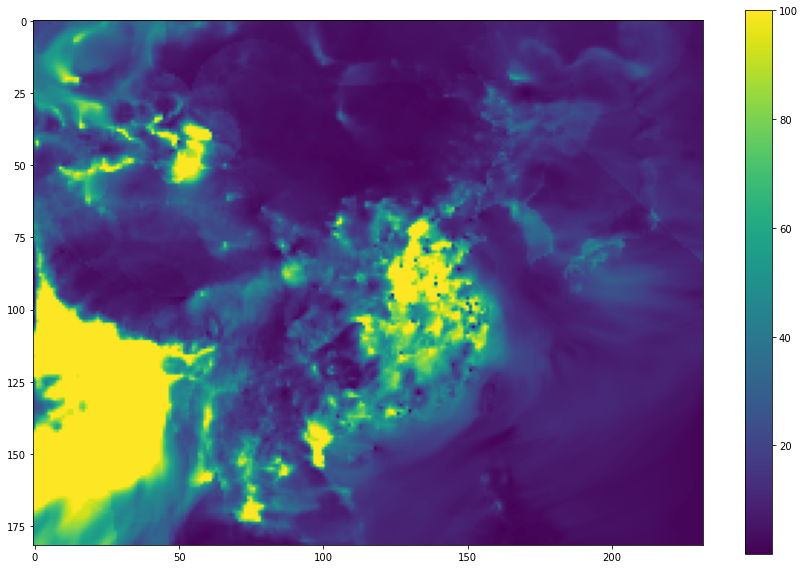

In [94]:
plt.imshow(a.transpose(1,0)[::-1])
plt.colorbar()
plt.show()

In [ ]:
res

In [50]:
res2.shape

(42224, 31)

In [ ]:
plt.rcParams['figure.figsize'] = (30,20)

for i in range(10):
    V = res[:,i].reshape(232,182).transpose(1,0)[::-1]
    e = res2[:,i].reshape(232,182).transpose(1,0)[::-1]
    
    m =min(np.max(V),np.max(e))
    V[V>m] =m 
    e[e>m] =m 

    
    plt.imshow(V)
    plt.colorbar()
    plt.show()
    
    plt.imshow(e)
    plt.colorbar()
    plt.show()
    
    print(i)

masked_array(
  data=[[23.869207124588616, 23.24562060260881, 21.726049795147777, ...,
         5.367337316098103, 5.365631716873472, 5.696171778703927],
        [25.68239326165484, 24.97780382047612, 23.556255068902814, ...,
         5.720000559501368, 5.641358480667561, 5.519973992471898],
        [26.154554550910063, 25.639327660600603, 24.757506030050187, ...,
         5.9741473352819465, 5.989594803630916, 5.667062385617798],
        ...,
        [0.35803340113711146, 0.35927290094205006, 0.3558937655487671,
         ..., 0.35502022231536345, 0.35770182412450685,
         0.35611621893682205],
        [0.35641056956881834, 0.35517152303956867, 0.35447347847868454,
         ..., 0.34953014418608663, 0.3499307517421679,
         0.3481592814048245],
        [0.34893131149803863, 0.34835477968913653, 0.3510856611125915,
         ..., 0.3468800292312269, 0.3469461619262653, 0.3466803263473521]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ...

In [ ]:
obs = ddata[:,10,0]
obs[obs==-999] = 0
CTM = simdata[10].transpose(1,0).reshape(-1)
print(obs.shape,CTM.shape)

In [33]:
CTM = np.repeat(np.expand_dims(CTM,axis = 1),

TypeError: _expand_dims_dispatcher() got an unexpected keyword argument 'dim'

In [ ]:
?np.re

In [ ]:
%%time
eVNA(obs,CTM,show = True)

In [20]:
%debug

> <ipython-input-18-1272b4056c2a>(16)eVNA()
     14     for i in range(len(region_neighbor)):
     15         _l = len(region_neighbor[i])
---> 16         region_neighbor[i] = region_neighbor[i]+[0]*(max_neighbor-_l)
     17         regions_sign[i,:_l] = 1
     18     region_neighbor  = np.array(region_neighbor)



ipdb>  region_neighbor[i]


array([  49,   64,   11, 1516,    3,    5,    0,    0,    0,    0,    0,
          0,    0])


ipdb>  [0]*(max_neighbor-_l)


[]


ipdb>  q


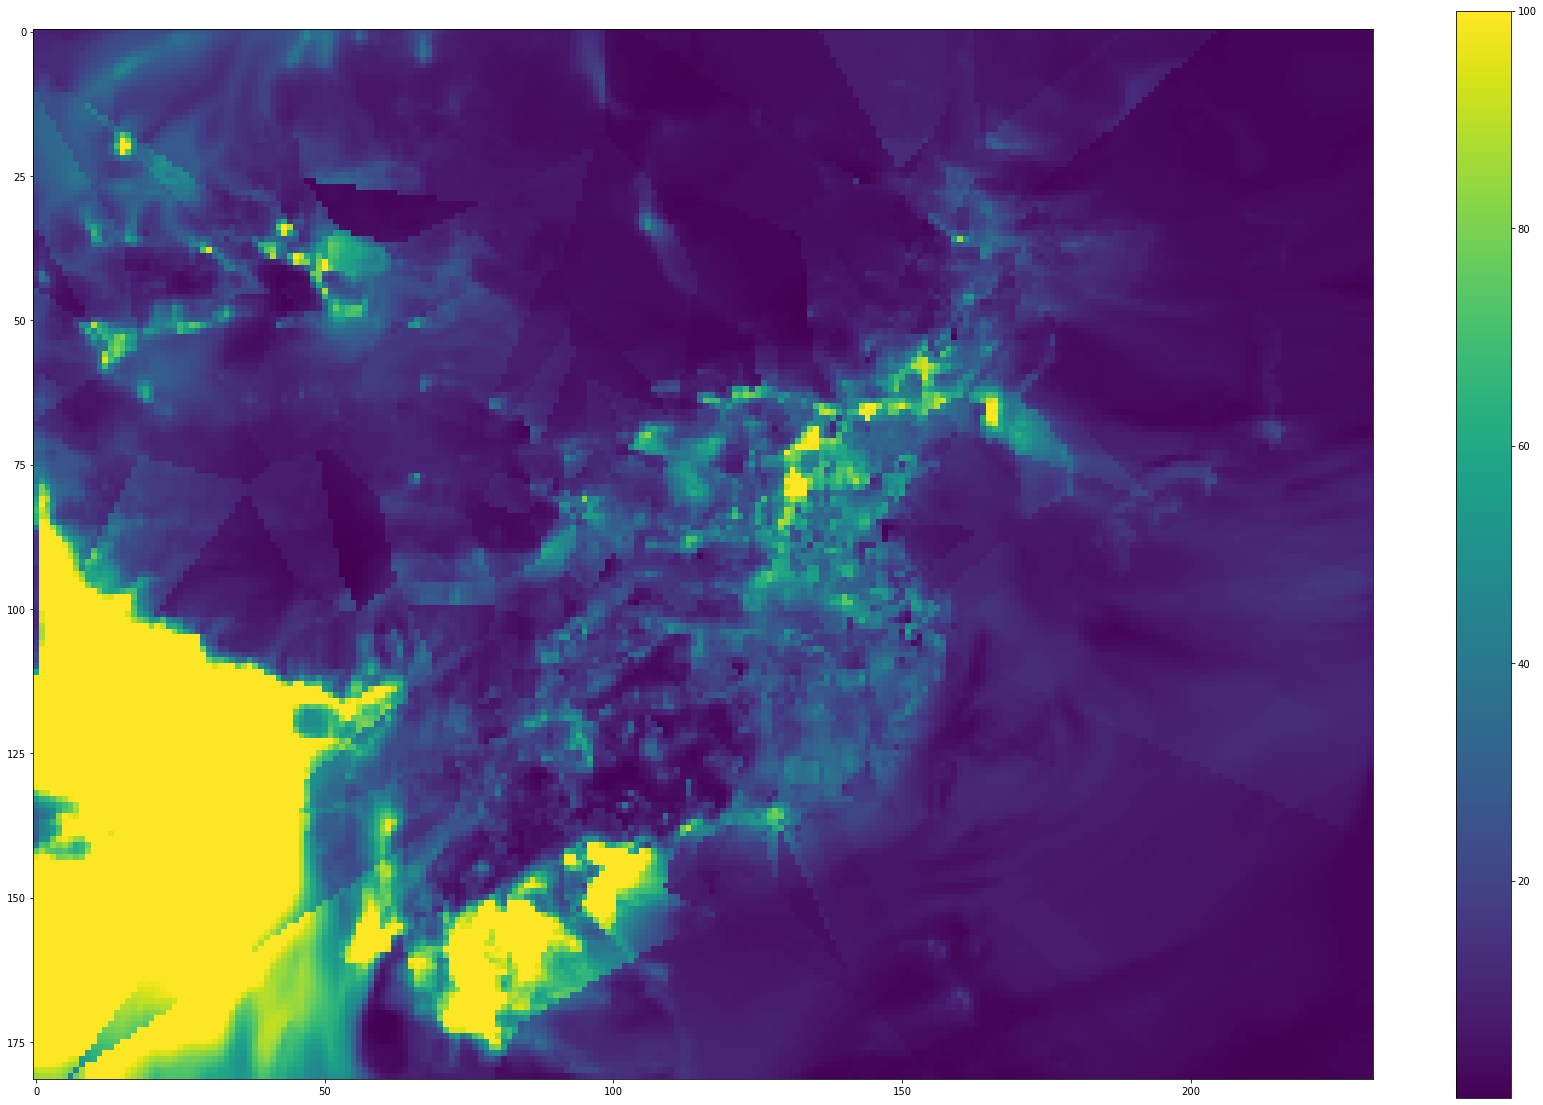

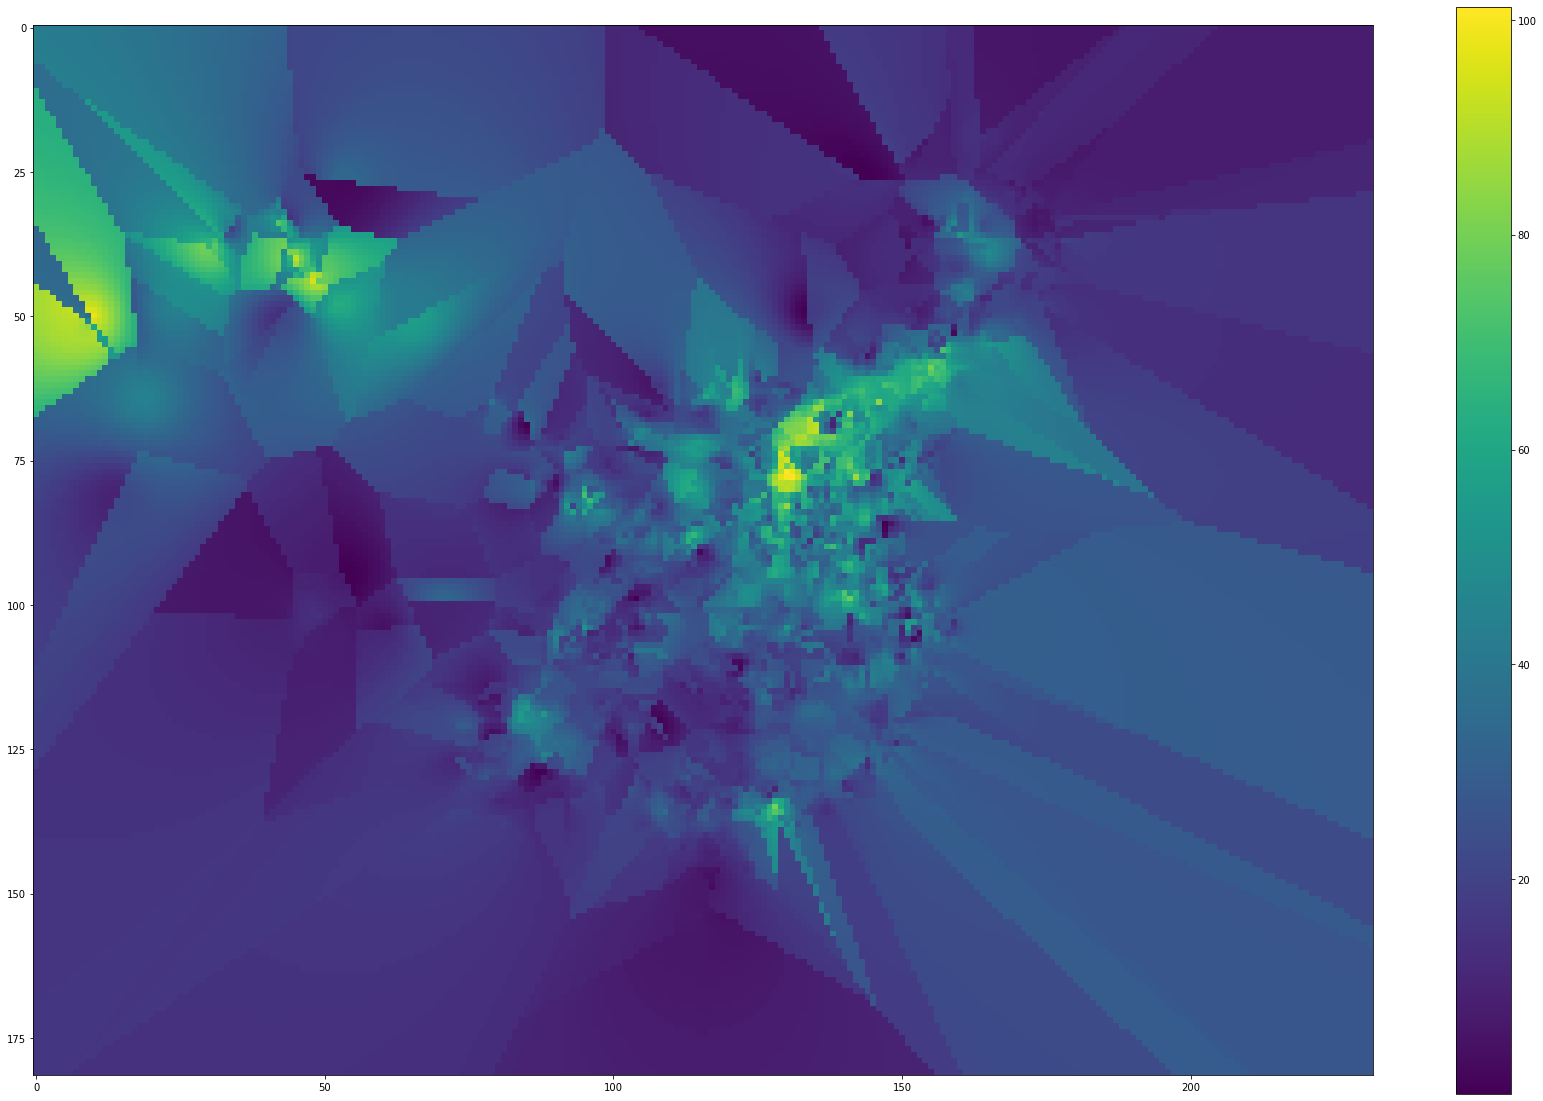

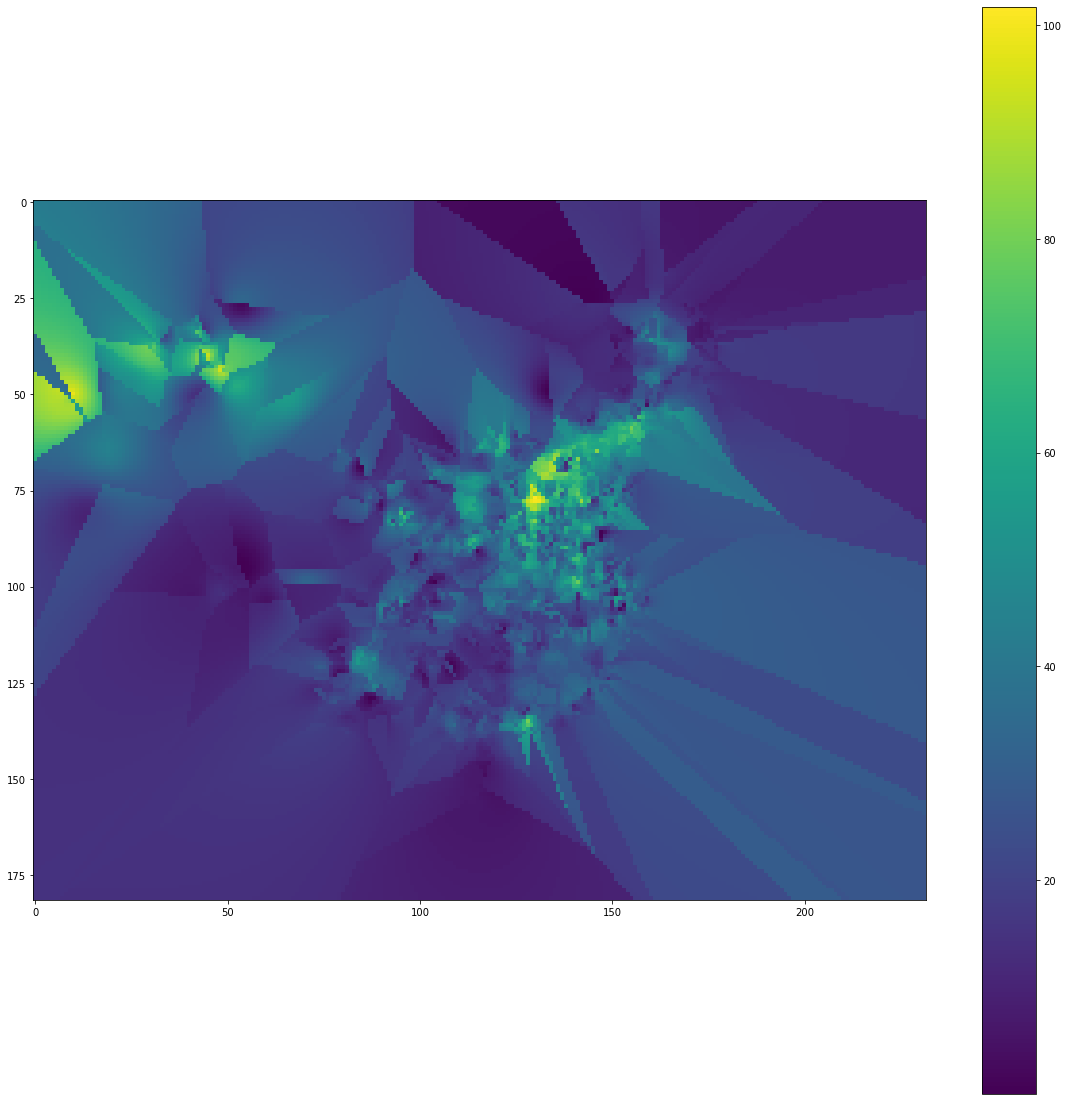

In [113]:
CTM[cell_neighbor].shape

IndexError: index 1382 is out of bounds for axis 0 with size 182

In [114]:
CTM.shape

(182, 232)

In [110]:
cell_neighbor.shape

(42224, 14)

In [88]:
cell_cluster.shape

(232, 182)

IndexError: index 2948 is out of bounds for axis 0 with size 1639

In [95]:
regions2lonlat = lonlatcolrow[:,:2]

(1639, 14)

In [ ]:
len2regions = 

In [62]:
np.

numpy.int32

TypeError: only integer scalar arrays can be converted to a scalar index

In [68]:
vor.regions[np.array([1,2,3])]

TypeError: only integer scalar arrays can be converted to a scalar index

In [70]:
a = np.random.randn(1700,3)

In [72]:
a[cell_cluster.reshape(-1)].shape

(42224, 3)

In [9]:
def eVNA(lonlatcolrow,ddata,simdata):
    s = 0
    list = []
    while(s < lonlatcolrow.shape[0]):
        #tmp = [lonlatcolrow[s,0],lonlatcolrow[s,1]]
        tmp = [lonlatcolrow[s,4],lonlatcolrow[s,5]]
        list.append(tmp)
        s = s + 1

    gridvalue = np.zeros((232,182),dtype=np.float)
    list.append([0,0])
    pnum = len(list)#points.shape[0]

    print("calculate")
    col = 0
    while(col<232):
        row = 0 
        while(row<182):
            modelE = simdata[row,col]
            grid = [-3118.5+27*col,-2443.5+27*row]
            #print(col,',',row,';',grid)
            list[pnum-1]=grid
            points = np.array(list)
            #plt.scatter(points[:,0], points[:,1])
            #plt.title('Points')
            #plt.xlim((72, 135))
            #plt.ylim((15, 55))
            #plt.show()

            #voronoi_kdtree = cKDTree(points)
            #grid = [100,50]
            #test_point_dist, test_point_regions = voronoi_kdtree.query(grid, k=1)

            vor = Voronoi(points,qhull_options='Qbb Qc Qx')
            #for i, reg in enumerate(vor.regions):
            #    print('Region:', i)
            #    print('Indices of vertices of Voronoi region:', reg)
            #    print('Associated point:', points[i], '\n')
            #fig = voronoi_plot_2d(vor)
            #fig.show()

            #distance = cdist(x1,x2,"euclidean")

            reg = vor.point_region[pnum-1]
            vert = vor.regions[reg]
            neighbors = []

            r = 0
            for vertices in vor.regions:
                same = 0
                for v in vert:
                    if(v in vertices):
                        same = same + 1
                    if(same>=2):
                        neighbors.append(r)
                r = r + 1

            neighborregions = np.unique(neighbors)

            neighborpoint = []
            for r in neighborregions:
                neighborpoint.append(vor.point_region.tolist().index(r))

            neighborpoint.remove(pnum-1)
            #print(neighborpoint)

            #neighborpointlonlat = np.zeros((len(neighborpoint),2),dtype=np.float)
            weight = np.zeros((len(neighborpoint)),dtype=np.float)
            pdata = np.zeros((len(neighborpoint)),dtype=np.float)
            modeli = np.zeros((len(neighborpoint)),dtype=np.float)
            i = 0
            #print(neighborpoint)
            for p in neighborpoint:
                pdata[i] = ddata[p,var-1]
                modeli[i] = simdata[int(lonlatcolrow[p,3]),int(lonlatcolrow[p,2])]
                x = vor.points[p]
                #neighborpointlonlat[i]=vor.points[p]
                weight[i] = np.power((x[0]-grid[0])**2 +(x[1]-grid[1])**2,1/2)
                i = i + 1

            weight = 1/(weight*weight)
            weight = weight/sum(weight)
            pdata[pdata<0] = 0
            gridvalue[col,row] = sum(pdata*modelE/modeli*weight)

            #print(gridvalue[col,row])
            row = row + 1 
        col = col + 1
    return gridvalue




In [12]:
obs_full = eVNA(lonlatcolrow,ddata[:,0],simdata[0])

calculate


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

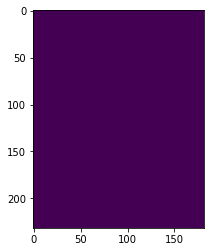

In [14]:
plt.imshow(obs_full)

In [16]:
print(np.sum(obs_full!=0))

0


In [11]:
simdata.shape

(31, 182, 232)